### **Импорты**

In [123]:
!pip install torch_geometric
!pip install spacy
!pip install networkx

In [124]:
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv
import torch
import spacy
import networkx as nx
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### **Загрузка и предобработка данных**

In [125]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [126]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7


### **Определение моделей графовых нейронных сетей (GCN, GAT и GraphSAGE)**

In [127]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

In [128]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

In [129]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GraphSAGE, self).__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.sage1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.sage2(x, edge_index)
        return x, F.log_softmax(x, dim=1)

### **Обучение и оценка моделей**

In [130]:
def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

In [131]:
def train(model, data, optimizer):
    criterion = torch.nn.CrossEntropyLoss()
    epochs = 200
    model.train()
    for epoch in range(epochs + 1):
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
    return model

In [132]:
def test(model, data):
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [137]:
gcn = GCN(dataset.num_features, 8, dataset.num_classes)
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
train(gcn, data, optimizer)
acc = test(gcn, data)
print(f'GCN test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.947 | Train Acc:  14.29% | Val Loss: 1.95 | Val Acc: 14.20%
Epoch  10 | Train Loss: 1.268 | Train Acc:  58.57% | Val Loss: 1.58 | Val Acc: 45.40%
Epoch  20 | Train Loss: 0.822 | Train Acc:  81.43% | Val Loss: 1.36 | Val Acc: 61.00%
Epoch  30 | Train Loss: 0.516 | Train Acc:  85.71% | Val Loss: 1.26 | Val Acc: 62.40%
Epoch  40 | Train Loss: 0.318 | Train Acc:  94.29% | Val Loss: 1.16 | Val Acc: 69.00%
Epoch  50 | Train Loss: 0.210 | Train Acc:  96.43% | Val Loss: 1.10 | Val Acc: 66.00%
Epoch  60 | Train Loss: 0.201 | Train Acc:  96.43% | Val Loss: 1.19 | Val Acc: 65.80%
Epoch  70 | Train Loss: 0.154 | Train Acc:  96.43% | Val Loss: 1.27 | Val Acc: 63.80%
Epoch  80 | Train Loss: 0.205 | Train Acc:  92.86% | Val Loss: 1.23 | Val Acc: 65.20%
Epoch  90 | Train Loss: 0.152 | Train Acc:  97.14% | Val Loss: 1.12 | Val Acc: 66.60%
Epoch 100 | Train Loss: 0.162 | Train Acc:  97.86% | Val Loss: 1.27 | Val Acc: 62.20%
Epoch 110 | Train Loss: 0.140 | Train Acc:  97.14% | V

In [134]:
gat = GAT(dataset.num_features, 8, dataset.num_classes)
optimizer = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)
train(gat, data, optimizer)
acc = test(gat, data)
print(f'GAT test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.922 | Train Acc:  17.14% | Val Loss: 1.94 | Val Acc: 12.20%
Epoch  10 | Train Loss: 0.358 | Train Acc:  98.57% | Val Loss: 0.94 | Val Acc: 76.80%
Epoch  20 | Train Loss: 0.068 | Train Acc: 100.00% | Val Loss: 0.84 | Val Acc: 76.00%
Epoch  30 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.96 | Val Acc: 74.20%
Epoch  40 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.98 | Val Acc: 74.20%
Epoch  50 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.91 | Val Acc: 74.20%
Epoch  60 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss: 0.98 | Val Acc: 74.20%
Epoch  70 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.93 | Val Acc: 72.20%
Epoch  80 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.96 | Val Acc: 74.00%
Epoch  90 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 0.93 | Val Acc: 74.20%
Epoch 100 | Train Loss: 0.012 | Train Acc: 100.00% | Val Loss: 0.94 | Val Acc: 74.20%
Epoch 110 | Train Loss: 0.011 | Train Acc: 100.00% | V

In [138]:
sage = GraphSAGE(dataset.num_features, 8, dataset.num_classes)
optimizer = torch.optim.Adam(sage.parameters(), lr=0.005, weight_decay=5e-4)
train(sage, data, optimizer)
acc = test(sage, data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 1.976 | Train Acc:  14.29% | Val Loss: 1.94 | Val Acc: 5.80%
Epoch  10 | Train Loss: 1.412 | Train Acc:  62.14% | Val Loss: 1.76 | Val Acc: 34.60%
Epoch  20 | Train Loss: 0.821 | Train Acc:  83.57% | Val Loss: 1.49 | Val Acc: 46.00%
Epoch  30 | Train Loss: 0.533 | Train Acc:  89.29% | Val Loss: 1.40 | Val Acc: 49.60%
Epoch  40 | Train Loss: 0.387 | Train Acc:  90.71% | Val Loss: 1.35 | Val Acc: 52.00%
Epoch  50 | Train Loss: 0.257 | Train Acc:  97.86% | Val Loss: 1.28 | Val Acc: 60.00%
Epoch  60 | Train Loss: 0.265 | Train Acc:  94.29% | Val Loss: 1.36 | Val Acc: 55.60%
Epoch  70 | Train Loss: 0.207 | Train Acc:  95.00% | Val Loss: 1.40 | Val Acc: 59.20%
Epoch  80 | Train Loss: 0.186 | Train Acc:  95.00% | Val Loss: 1.31 | Val Acc: 59.40%
Epoch  90 | Train Loss: 0.185 | Train Acc:  97.14% | Val Loss: 1.31 | Val Acc: 60.60%
Epoch 100 | Train Loss: 0.192 | Train Acc:  95.00% | Val Loss: 1.34 | Val Acc: 60.00%
Epoch 110 | Train Loss: 0.155 | Train Acc:  96.43% | Va

### **Визуализация результатов**

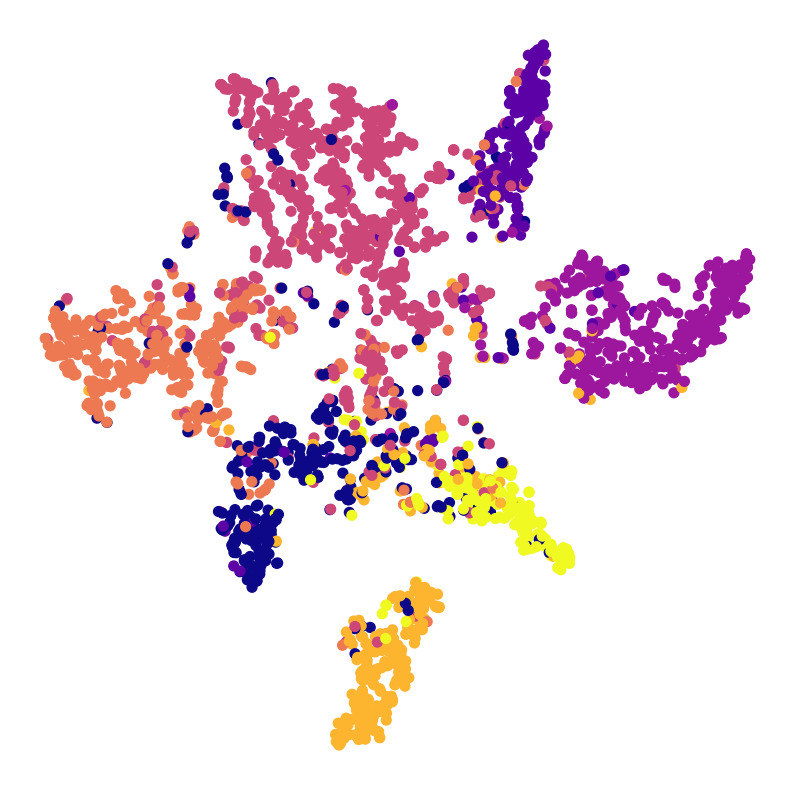

In [147]:
h, _ = gcn(data.x, data.edge_index)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(h.detach())
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y, cmap='plasma')
plt.show()

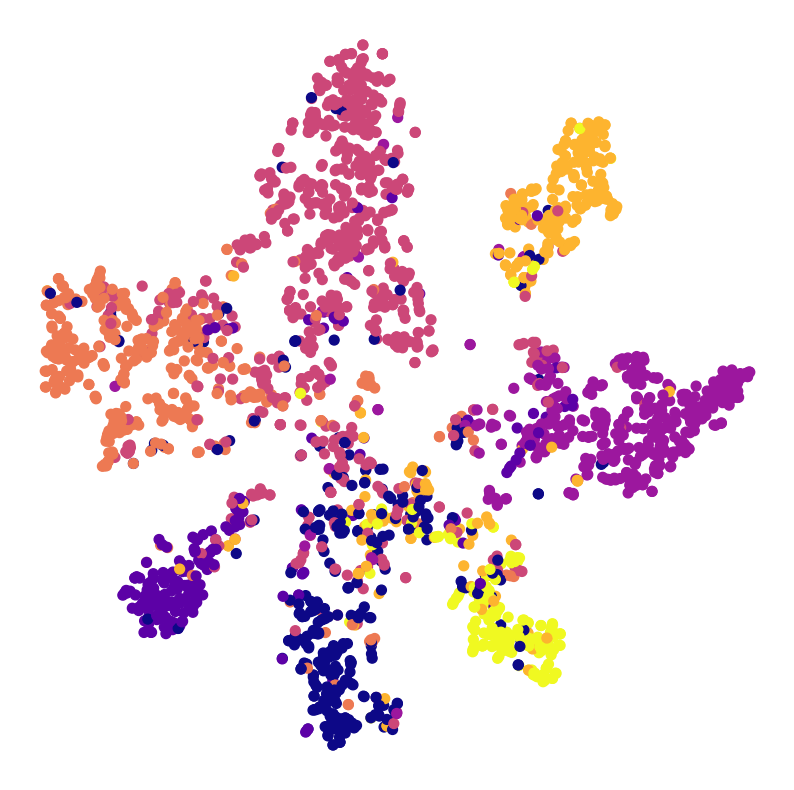

In [148]:
h, _ = gat(data.x, data.edge_index)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(h.detach())
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y, cmap='plasma')
plt.show()

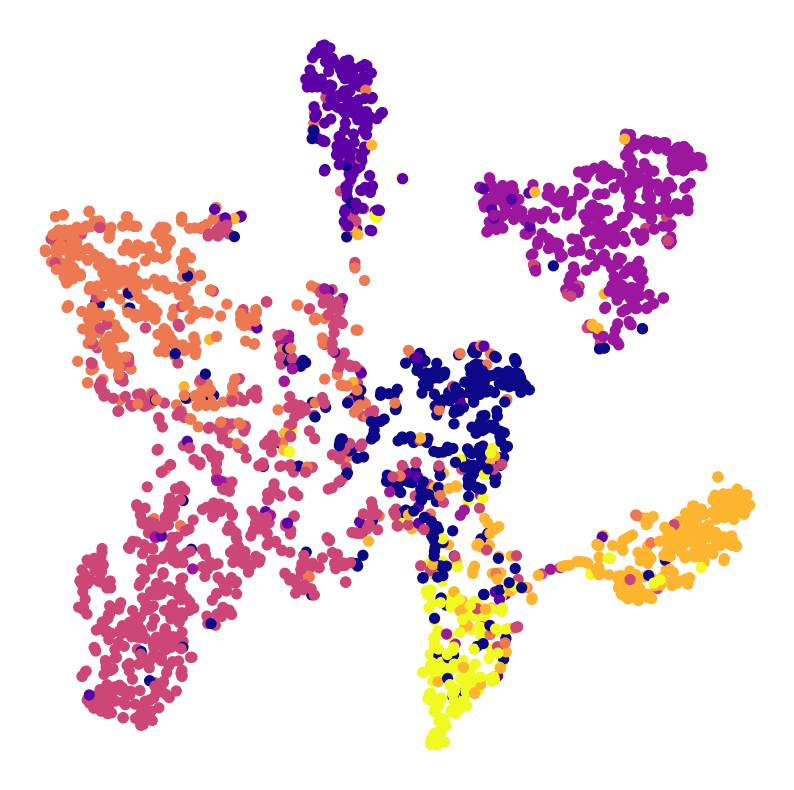

In [149]:
h, _ = sage(data.x, data.edge_index)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(h.detach())
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y, cmap='plasma')
plt.show()

## Обучение на тексте

### **Загрузка текста и построение графа**

In [89]:
nlp = spacy.load("en_core_web_sm")

text = """
Isaac Newton, born on January 4, 1643, in Woolsthorpe, England, was one of the most influential scientists in history. His work laid the foundation for classical mechanics and significantly impacted various scientific fields, including mathematics, astronomy, and optics. Newton's most famous work, "Philosophiæ Naturalis Principia Mathematica" (Mathematical Principles of Natural Philosophy), commonly known as the "Principia," was published in 1687 and introduced the three laws of motion, which form the core principles of modern physics. These laws describe the relationship between a body and the forces acting on it, laying the groundwork for the study of mechanics.
Newton's first law, the law of inertia, states that an object will remain at rest or in uniform motion unless acted upon by an external force. His second law establishes the relationship between an object's mass, acceleration, and the applied force (F=ma). The third law states that for every action, there is an equal and opposite reaction. These laws not only revolutionized the understanding of motion and mechanics but also provided the basis for the development of various technologies and engineering principles that followed.
In addition to his groundbreaking work in mechanics, Newton made significant contributions to the field of optics. He conducted experiments with prisms and demonstrated that white light is composed of a spectrum of colors. Newton's book "Opticks," published in 1704, detailed his experiments and theories on light and color. He proposed the particle theory of light, suggesting that light is composed of small particles, which was a major step forward in the study of optics and the nature of light.
Newton's contributions to mathematics were equally profound. He co-developed calculus, independently and simultaneously with the German mathematician Gottfried Wilhelm Leibniz. This mathematical framework became an essential tool for scientists and engineers, enabling the precise description and analysis of changing quantities. Newton's work in calculus included the development of the binomial theorem and the method of fluxions, which became fundamental to the study of mathematics and physics.
Despite his immense scientific achievements, Newton's personal life was complex and often marked by periods of intense focus and isolation. He was born prematurely and had a difficult childhood, losing his father before he was born and being raised by his grandmother after his mother remarried. Newton's early education was disrupted by his mother's attempts to make him a farmer, but he eventually returned to school and showed exceptional talent in mathematics and science.
In 1661, Newton entered Trinity College, Cambridge, where he immersed himself in the study of mathematics, physics, and astronomy. His early work was heavily influenced by the writings of René Descartes, Johannes Kepler, and Galileo Galilei. Newton's intellectual pursuits led to his appointment as a fellow of Trinity College in 1667 and later as the Lucasian Professor of Mathematics in 1669, a position he held for many years.
Newton's later years were marked by his involvement in various administrative and political roles. In 1696, he was appointed Warden of the Royal Mint, where he played a crucial role in reforming England's currency and combating counterfeiting. Newton's dedication to this role demonstrated his meticulous nature and his ability to apply scientific principles to practical problems.
Throughout his life, Newton maintained a keen interest in alchemy and biblical chronology. He devoted considerable time to studying ancient texts and conducting alchemical experiments, hoping to uncover hidden truths about the natural world and the divine. Although these pursuits did not yield significant scientific discoveries, they reflected Newton's deep curiosity and his desire to understand the fundamental principles governing the universe.
Newton's legacy extends far beyond his scientific achievements. His work laid the groundwork for the Enlightenment and the Scientific Revolution, inspiring generations of scientists, philosophers, and thinkers. Newton's principles of motion and universal gravitation provided the framework for the study of physics for centuries and influenced the development of modern science.
Newton's influence can be seen in various aspects of modern life, from the engineering principles that underpin modern technology to the mathematical techniques used in scientific research and financial modeling. His contributions to the understanding of light and optics paved the way for advances in various fields, including photography, telecommunications, and medicine.
Isaac Newton passed away on March 31, 1727, leaving behind a legacy that continues to shape the scientific world. His life and work exemplify the power of human curiosity, intellect, and perseverance. Newton's relentless pursuit of knowledge and his ability to synthesize complex ideas into fundamental principles have made him one of the most revered figures in the history of science.
"""


In [90]:
doc = nlp(text)
G = nx.Graph()
for ent in doc.ents:
    G.add_node(ent.text, label=ent.label_)
for token in doc:
    if token.dep_ == "ROOT":
        subject = [w for w in token.lefts if w.dep_ == "nsubj"]
        if subject:
            subject = subject[0]
            G.add_edge(subject.text, token.text)
        for child in token.children:
            if child.dep_ == "attr" or child.dep_ == "dobj":
                G.add_edge(token.text, child.text)
for node in G.nodes():
    if 'label' not in G.nodes[node]:
        G.nodes[node]['label'] = 'None'

In [91]:
# Преобразование графа в формат, совместимый с PyTorch Geometric
data = from_networkx(G)
le = LabelEncoder()
labels = [G.nodes[node]['label'] for node in G.nodes]
encoded_labels = le.fit_transform(labels)
data.y = torch.tensor(encoded_labels, dtype=torch.long)
num_nodes = data.num_nodes
data.x = torch.eye(num_nodes, dtype=torch.float)

### **Определение и обучение модели GCN**

In [92]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [93]:
model = GCN(in_channels=num_nodes, hidden_channels=16, out_channels=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [94]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [95]:
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

Epoch 0, Loss: 2.487877368927002
Epoch 10, Loss: 2.0103466510772705
Epoch 20, Loss: 1.3197581768035889
Epoch 30, Loss: 0.8394095301628113
Epoch 40, Loss: 0.5852585434913635
Epoch 50, Loss: 0.37626227736473083
Epoch 60, Loss: 0.2350490391254425
Epoch 70, Loss: 0.1443985551595688
Epoch 80, Loss: 0.09215051680803299
Epoch 90, Loss: 0.06336304545402527
Epoch 100, Loss: 0.04812938719987869
Epoch 110, Loss: 0.039706144481897354
Epoch 120, Loss: 0.03420707955956459
Epoch 130, Loss: 0.030056415125727654
Epoch 140, Loss: 0.026639945805072784
Epoch 150, Loss: 0.023680949583649635
Epoch 160, Loss: 0.021052883937954903
Epoch 170, Loss: 0.018698232248425484
Epoch 180, Loss: 0.016619207337498665
Epoch 190, Loss: 0.014764873310923576


In [96]:
model.eval()
out = model(data)
_, pred = out.max(dim=1)
correct = int(pred.eq(data.y).sum().item())
accuracy = correct / num_nodes
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


In [97]:
pred_labels = le.inverse_transform(pred.cpu().numpy())
true_labels = le.inverse_transform(data.y.cpu().numpy())
for i, node in enumerate(G.nodes()):
    print(f'Node: {node}, True Label: {true_labels[i]}, Predicted Label: {pred_labels[i]}')

Node: Isaac Newton, True Label: PERSON, Predicted Label: PERSON
Node: January 4, 1643, True Label: DATE, Predicted Label: DATE
Node: Woolsthorpe, True Label: GPE, Predicted Label: GPE
Node: England, True Label: GPE, Predicted Label: GPE
Node: Newton, True Label: ORG, Predicted Label: ORG
Node: Philosophiæ Naturalis Principia Mathematica, True Label: PERSON, Predicted Label: PERSON
Node: Principia, True Label: WORK_OF_ART, Predicted Label: WORK_OF_ART
Node: 1687, True Label: DATE, Predicted Label: DATE
Node: three, True Label: CARDINAL, Predicted Label: CARDINAL
Node: first, True Label: ORDINAL, Predicted Label: ORDINAL
Node: second, True Label: ORDINAL, Predicted Label: ORDINAL
Node: third, True Label: ORDINAL, Predicted Label: ORDINAL
Node: Opticks, True Label: WORK_OF_ART, Predicted Label: WORK_OF_ART
Node: 1704, True Label: DATE, Predicted Label: DATE
Node: German, True Label: NORP, Predicted Label: NORP
Node: Gottfried Wilhelm Leibniz, True Label: PERSON, Predicted Label: PERSON
No

### **Определение и обучение модели GAT**

In [98]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATv2Conv(hidden_channels * heads, out_channels, heads=heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [99]:
gat_model = GAT(in_channels=num_nodes, hidden_channels=16, out_channels=len(le.classes_), heads=2)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01)

In [100]:
def train_gat():
    gat_model.train()
    gat_optimizer.zero_grad()
    out = gat_model(data)
    loss = criterion(out, data.y)
    loss.backward()
    gat_optimizer.step()
    return loss.item()

In [101]:
for epoch in range(200):
    loss = train_gat()
    if epoch % 10 == 0:
        print(f'GAT Epoch {epoch}, Loss: {loss}')

GAT Epoch 0, Loss: 3.23341703414917
GAT Epoch 10, Loss: 1.6772279739379883
GAT Epoch 20, Loss: 0.8494511246681213
GAT Epoch 30, Loss: 0.4173615276813507
GAT Epoch 40, Loss: 0.17763270437717438
GAT Epoch 50, Loss: 0.06735134869813919
GAT Epoch 60, Loss: 0.03645704686641693
GAT Epoch 70, Loss: 0.027278568595647812
GAT Epoch 80, Loss: 0.023641161620616913
GAT Epoch 90, Loss: 0.021791070699691772
GAT Epoch 100, Loss: 0.02066793292760849
GAT Epoch 110, Loss: 0.019894598051905632
GAT Epoch 120, Loss: 0.019315524026751518
GAT Epoch 130, Loss: 0.018858494237065315
GAT Epoch 140, Loss: 0.018485231325030327
GAT Epoch 150, Loss: 0.018172940239310265
GAT Epoch 160, Loss: 0.017907995730638504
GAT Epoch 170, Loss: 0.017680561169981956
GAT Epoch 180, Loss: 0.017482556402683258
GAT Epoch 190, Loss: 0.017306886613368988


In [102]:
gat_model.eval()
out = gat_model(data)
_, pred = out.max(dim=1)
correct = int(pred.eq(data.y).sum().item())
accuracy = correct / num_nodes
print(f'GAT Accuracy: {accuracy:.4f}')

GAT Accuracy: 1.0000


In [103]:
pred_labels = le.inverse_transform(pred.cpu().numpy())
true_labels = le.inverse_transform(data.y.cpu().numpy())
for i, node in enumerate(G.nodes()):
    print(f'GAT Node: {node}, True Label: {true_labels[i]}, Predicted Label: {pred_labels[i]}')

GAT Node: Isaac Newton, True Label: PERSON, Predicted Label: PERSON
GAT Node: January 4, 1643, True Label: DATE, Predicted Label: DATE
GAT Node: Woolsthorpe, True Label: GPE, Predicted Label: GPE
GAT Node: England, True Label: GPE, Predicted Label: GPE
GAT Node: Newton, True Label: ORG, Predicted Label: ORG
GAT Node: Philosophiæ Naturalis Principia Mathematica, True Label: PERSON, Predicted Label: PERSON
GAT Node: Principia, True Label: WORK_OF_ART, Predicted Label: WORK_OF_ART
GAT Node: 1687, True Label: DATE, Predicted Label: DATE
GAT Node: three, True Label: CARDINAL, Predicted Label: CARDINAL
GAT Node: first, True Label: ORDINAL, Predicted Label: ORDINAL
GAT Node: second, True Label: ORDINAL, Predicted Label: ORDINAL
GAT Node: third, True Label: ORDINAL, Predicted Label: ORDINAL
GAT Node: Opticks, True Label: WORK_OF_ART, Predicted Label: WORK_OF_ART
GAT Node: 1704, True Label: DATE, Predicted Label: DATE
GAT Node: German, True Label: NORP, Predicted Label: NORP
GAT Node: Gottfried

### **Определение и обучение модели GraphSAGE**

In [104]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [105]:
sage_model = GraphSAGE(in_channels=num_nodes, hidden_channels=16, out_channels=len(le.classes_))
sage_optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.01)

In [106]:
def train_sage():
    sage_model.train()
    sage_optimizer.zero_grad()
    out = sage_model(data)
    loss = criterion(out, data.y)
    loss.backward()
    sage_optimizer.step()
    return loss.item()

In [107]:
for epoch in range(200):
    loss = train_sage()
    if epoch % 10 == 0:
        print(f'SAGE Epoch {epoch}, Loss: {loss}')

SAGE Epoch 0, Loss: 2.5207583904266357
SAGE Epoch 10, Loss: 1.6648728847503662
SAGE Epoch 20, Loss: 0.8385830521583557
SAGE Epoch 30, Loss: 0.6556652784347534
SAGE Epoch 40, Loss: 0.47153785824775696
SAGE Epoch 50, Loss: 0.32171523571014404
SAGE Epoch 60, Loss: 0.21132424473762512
SAGE Epoch 70, Loss: 0.12829969823360443
SAGE Epoch 80, Loss: 0.07877086848020554
SAGE Epoch 90, Loss: 0.05365873500704765
SAGE Epoch 100, Loss: 0.04110599681735039
SAGE Epoch 110, Loss: 0.034272994846105576
SAGE Epoch 120, Loss: 0.02958858199417591
SAGE Epoch 130, Loss: 0.02545398287475109
SAGE Epoch 140, Loss: 0.02133314684033394
SAGE Epoch 150, Loss: 0.0171655286103487
SAGE Epoch 160, Loss: 0.013194231316447258
SAGE Epoch 170, Loss: 0.009800435975193977
SAGE Epoch 180, Loss: 0.007248106878250837
SAGE Epoch 190, Loss: 0.005515041761100292


In [108]:
sage_model.eval()
out = sage_model(data)
_, pred = out.max(dim=1)
correct = int(pred.eq(data.y).sum().item())
accuracy = correct / num_nodes
print(f'SAGE Accuracy: {accuracy:.4f}')

SAGE Accuracy: 1.0000


In [109]:
pred_labels = le.inverse_transform(pred.cpu().numpy())
true_labels = le.inverse_transform(data.y.cpu().numpy())
for i, node in enumerate(G.nodes()):
    print(f'SAGE Node: {node}, True Label: {true_labels[i]}, Predicted Label: {pred_labels[i]}')

SAGE Node: Isaac Newton, True Label: PERSON, Predicted Label: PERSON
SAGE Node: January 4, 1643, True Label: DATE, Predicted Label: DATE
SAGE Node: Woolsthorpe, True Label: GPE, Predicted Label: GPE
SAGE Node: England, True Label: GPE, Predicted Label: GPE
SAGE Node: Newton, True Label: ORG, Predicted Label: ORG
SAGE Node: Philosophiæ Naturalis Principia Mathematica, True Label: PERSON, Predicted Label: PERSON
SAGE Node: Principia, True Label: WORK_OF_ART, Predicted Label: WORK_OF_ART
SAGE Node: 1687, True Label: DATE, Predicted Label: DATE
SAGE Node: three, True Label: CARDINAL, Predicted Label: CARDINAL
SAGE Node: first, True Label: ORDINAL, Predicted Label: ORDINAL
SAGE Node: second, True Label: ORDINAL, Predicted Label: ORDINAL
SAGE Node: third, True Label: ORDINAL, Predicted Label: ORDINAL
SAGE Node: Opticks, True Label: WORK_OF_ART, Predicted Label: WORK_OF_ART
SAGE Node: 1704, True Label: DATE, Predicted Label: DATE
SAGE Node: German, True Label: NORP, Predicted Label: NORP
SAGE

### **Визуализация графа**

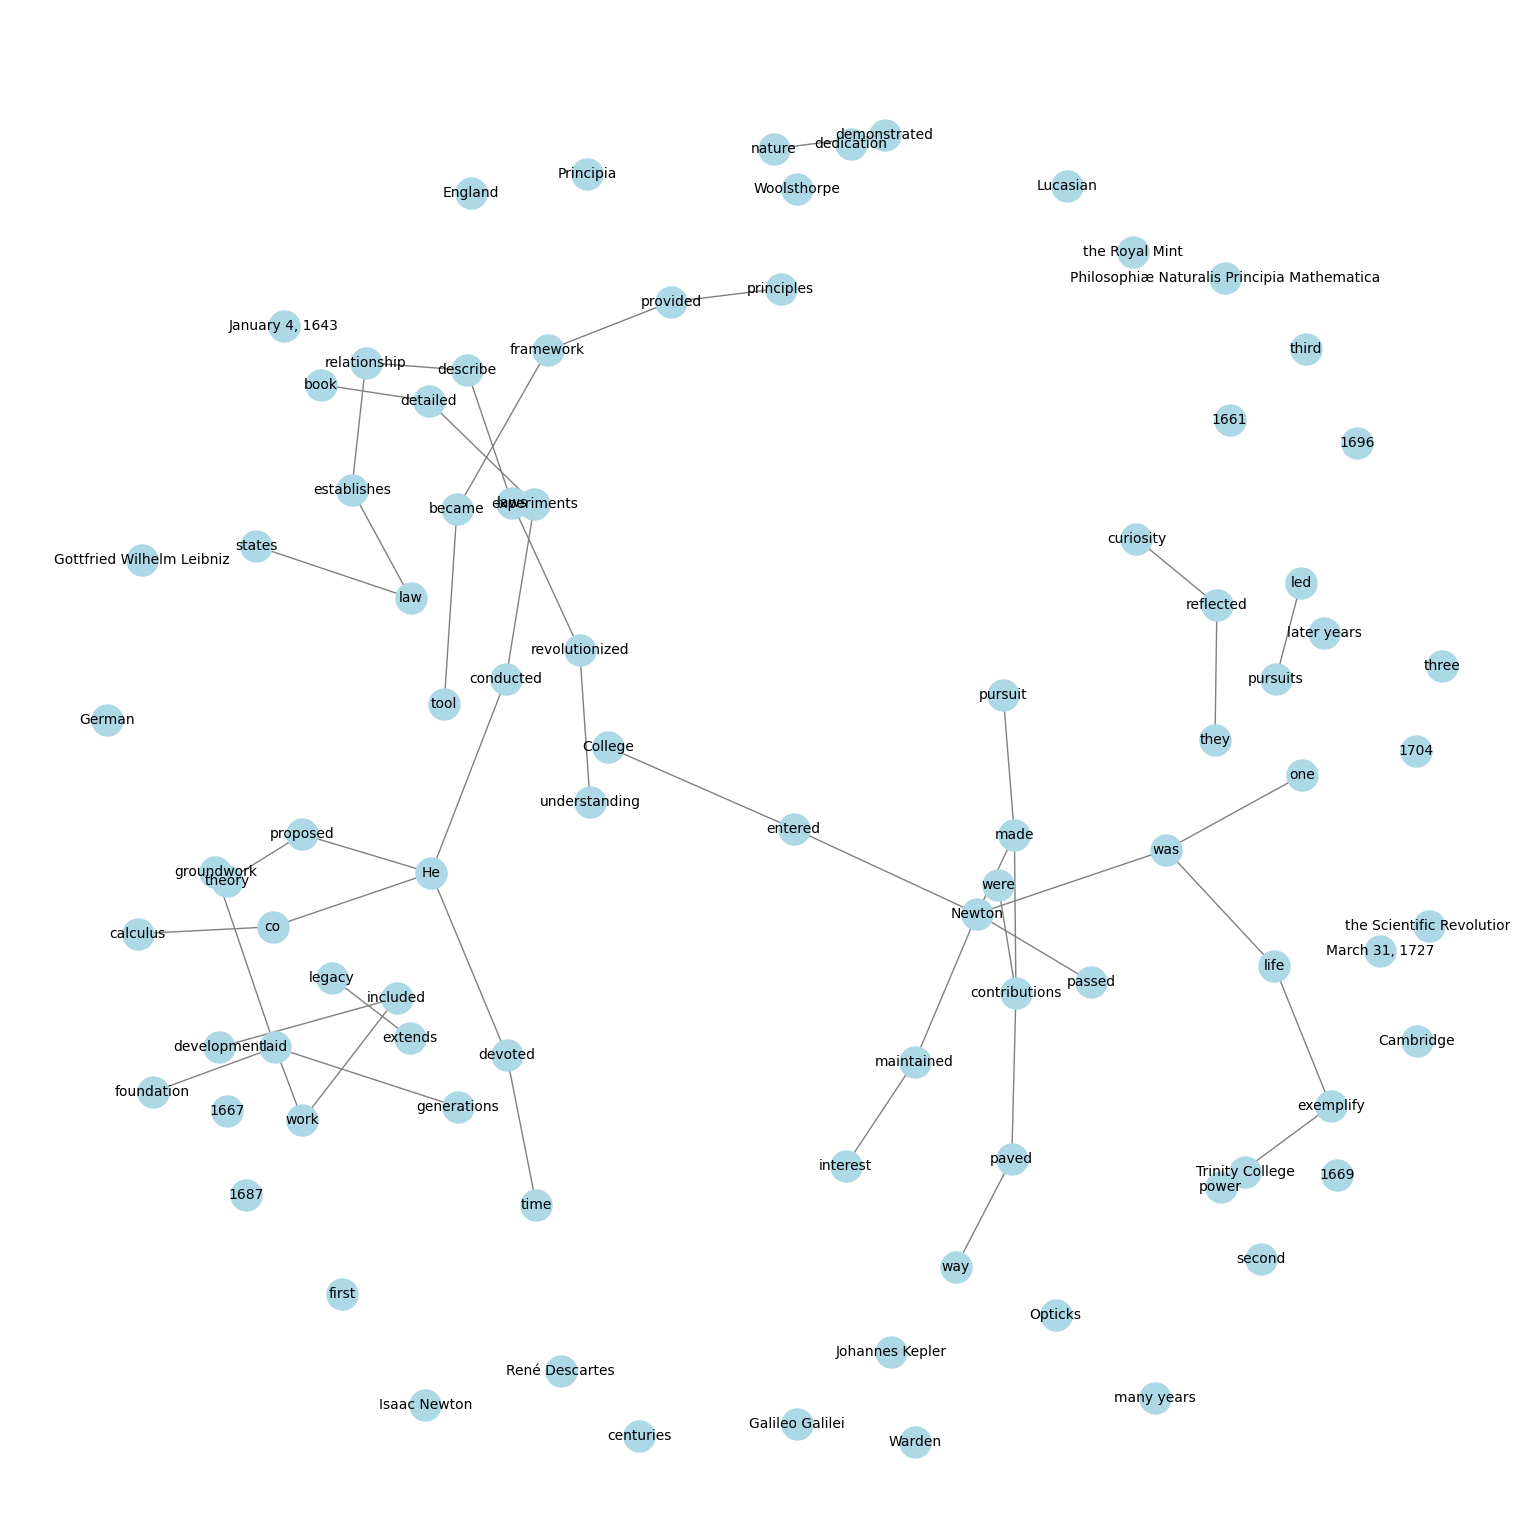

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.3)

nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, edge_color='gray')
plt.show()